In [3]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai


In [8]:
newsgroups_train = fetch_20newsgroups(subset='train')
print(list(newsgroups_train.target_names))
categories = ['rec.autos', 'rec.motorcycles']

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [9]:
auto_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

In [10]:
print(auto_dataset['data'][0])

From: gregl@zimmer.CSUFresno.EDU (Greg Lewis)
Subject: Re: WARNING.....(please read)...
Keywords: BRICK, TRUCK, DANGER
Nntp-Posting-Host: zimmer.csufresno.edu
Organization: CSU Fresno
Lines: 33

In article <1qh336INNfl5@CS.UTK.EDU> larose@austin.cs.utk.edu (Brian LaRose) writes:
>This just a warning to EVERYBODY on the net.  Watch out for
>folks standing NEXT to the road or on overpasses.   They can
>cause SERIOUS HARM to you and your car.  
>
>(just a cliff-notes version of my story follows)
>
>10pm last night, I was travelling on the interstate here in
>knoxville,  I was taking an offramp exit to another interstate
>and my wife suddenly screamed and something LARGE hit the side
>of my truck.  We slowed down, but after looking back to see the
>vandals standing there, we drove on to the police station.
>
>She did get a good look at the guy and saw him "cock his arm" with
>something the size of a cinderblock, BUT I never saw him. We are 
>VERY lucky the truck sits up high on the road; i

In [12]:
auto_dataset.target_names[auto_dataset['target'][0]]

'rec.autos'

In [13]:
len_all, len_autos, len_motors = len(auto_dataset.data), len([e for e in auto_dataset.target if e == 0]), len([e for e in auto_dataset.target if e == 1])
print(f"Total examples: {len_all}, autos {len_autos}, motor cycles {len_motors}")

Total examples: 1192, autos 594, motor cycles 598


In [14]:
import pandas as pd

In [17]:
labels = [auto_dataset.target_names[x].split('.')[-1] for x in auto_dataset['target']]
texts = [text.strip() for text in auto_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt', 'completion'])
df.head()

,prompt,completion
0,From: gregl@zimmer.CSUFresno.EDU (Greg Lewis)\...,autos
1,From: cjackson@adobe.com (Curtis Jackson)\nSub...,motorcycles
2,From: Clarke@bdrc.bd.com (Richard Clarke)\nSub...,motorcycles
3,From: zorro@picasso.ocis.temple.edu (John Grab...,autos
4,From: marshatt@feserve.cc.purdue.edu (Zauberer...,autos


In [19]:
df.to_json('auto.jsonl', orient='records', lines=True)

In [21]:
!openai tools fine_tunes.prepare_data -f auto.jsonl -q

Analyzing...

- Your file contains 1192 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 5 examples that are very long. These are rows: [38, 203, 910, 1057, 1130]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
- The completion should star

In [22]:
!openai api fine_tunes.create -t "auto_prepared_train.jsonl" -v "auto_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " autos" -m ada

Upload progress: 100%|█████████████████████| 1.35M/1.35M [00:00<00:00, 882Mit/s]
Uploaded file from auto_prepared_train.jsonl: file-7q7paCFpMfJTu2VKO0tQllED
Upload progress: 100%|███████████████████████| 320k/320k [00:00<00:00, 704Mit/s]
Uploaded file from auto_prepared_valid.jsonl: file-qnVeJMzrdLhUVkmwAJdeSsAf
Created fine-tune: ft-UPUJY1teImmxbOnJZryACV72
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-03-06 14:34:24] Created fine-tune: ft-UPUJY1teImmxbOnJZryACV72

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-UPUJY1teImmxbOnJZryACV72



In [26]:
!openai api fine_tunes.follow -i ft-UPUJY1teImmxbOnJZryACV72

[2023-03-06 14:34:24] Created fine-tune: ft-UPUJY1teImmxbOnJZryACV72
[2023-03-06 14:38:22] Fine-tune costs $0.65
[2023-03-06 14:38:22] Fine-tune enqueued. Queue number: 0
[2023-03-06 14:38:25] Fine-tune started
[2023-03-06 14:41:28] Completed epoch 1/4
[2023-03-06 14:44:26] Completed epoch 2/4
[2023-03-06 14:47:03] Completed epoch 3/4
[2023-03-06 14:50:17] Completed epoch 4/4
[2023-03-06 14:50:42] Uploaded model: ada:ft-personal-2023-03-06-20-50-42
[2023-03-06 14:50:43] Uploaded result file: file-OaDIA7xBcoCNmBr9vYqD25oD
[2023-03-06 14:50:43] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-personal-2023-03-06-20-50-42 -p <YOUR_PROMPT>


In [27]:
!openai api completions.create -m ada:ft-personal-2023-03-06-20-50-42 -p "I'm driving a Honda."

I'm driving a Honda Insight, and in the after hours, I'm pretty sure I raise it up

In [28]:
!openai api fine_tunes.results -i ft-UPUJY1teImmxbOnJZryACV72 > result.csv

In [29]:
results = pd.read_csv('result.csv')
results[results['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
3793,3794,1629970,3794,0.025149,1.0,1.0,NaN,NaN,NaN,0.97479,0.966942,0.983193,0.998729,0.998756,0.975


<Axes: >

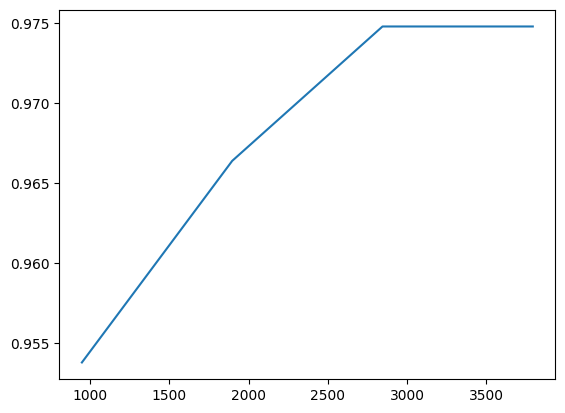

In [31]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

In [32]:
test = pd.read_json('auto_prepared_valid.jsonl', lines=True)
test.head()

,prompt,completion
0,From: cjackson@adobe.com (Curtis Jackson)\nSub...,motorcycles
1,From: ravi@merlin.dev.cdx.mot.com (Ravi Puvval...,autos
2,From: music@erich.triumf.ca (FRED W. BACH)\nSu...,autos
3,From: essbaum@rchland.vnet.ibm.com (Alexander ...,motorcycles
4,From: nuet_ke@pts.mot.com (KEITH NUETZMAN X315...,autos


In [33]:
ft_model = 'ada:ft-personal-2023-03-06-20-50-42'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']

' motorcycles'